##### Experiment 5
* Use gensim for phrase based tokenization

In [21]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import re
import threading
import multiprocessing
import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import string
import unicodedata
import nltk

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, QuantileTransformer
import lightgbm as lgb
from sklearn import metrics
import gc

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
# from __future__ import print_function
np.random.seed(786)  # for reproducibility

from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,  KerasRegressor
#Some classes
#Functions we need - Feature Selector, Fasttext_Estimator, Preprocessing Transformer, Binary_Encoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.sparse.csr import csr_matrix
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    print(np.min(y_pred), np.max(y_pred))
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse, greater_is_better=False)

def get_obj_cols(df):
    """Return columns with object dtypes"""
    obj_cols = []
    for idx, dt in enumerate(df.dtypes):
        if dt == 'object':
            obj_cols.append(df.columns.values[idx])

    return obj_cols


def convert_input(X):
    """if input not a dataframe convert it to one"""
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, list):
            X = pd.DataFrame(np.array(X))
        elif isinstance(X, (np.generic, np.ndarray)):
            X = pd.DataFrame(X)
        elif isinstance(X, csr_matrix):
            X = pd.SparseDataFrame(X)
        else:
            raise ValueError('Unexpected input type: %s' % (str(type(X))))

        #X = X.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """ Class to do subset of features in sklearn pipeline"""
    def __init__(self, cols=None, return_df=True, verbose=0):
        self.cols = cols
        self.return_df = return_df
        self.verbose = verbose
        
    def fit(self, X, y=None):
        #Do nothing
        return self
    
    def transform(self, X, y=None):
        #if the input dataset isn't already a dataframe, convert it to one
        X = X.copy(deep=True)
        X = convert_input(X)
        X = X.loc[:, self.col]
        
        if self.verbose:
            print("Selecting columns are {}".format(self.col))
        if self.return_df:
            return X
        else:
            return X.values

        



class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, thresh=0, func=np.mean, add_to_orig=False):
        self.cols = cols
        self.thresh = thresh
        self.func = func
        self.add_to_orig = add_to_orig
    
    #@numba.jit        
    def fit(self, X, y):
        self.prior = self.func(y)
        self._dict = {}
        for col in self.cols:
            if isinstance(col, (list, tuple)):
                print('here')
                tmp_df = X.loc[: ,col]
                col = tuple(col)
            else:
                tmp_df = X.loc[: ,[col]]
            tmp_df['y'] = y
            print(tmp_df.columns)
            #tmp_df = pd.DataFrame({'eval_col':X[col].values, 'y':y})
            if isinstance(col, (list, tuple)):
                print('here')
                col = tuple(col)
            self._dict[col] = tmp_df.groupby(col)['y'].apply(lambda x: 
                                self.func(x) if len(x) >= self.thresh  else self.prior).to_dict()
                                
            del tmp_df
        return self
    #@numba.jit
    def transform(self, X, y=None):
        X_transformed = []
        for col in self.cols:
            
            if isinstance(col, (list, tuple)):
                tmp_df = X.loc[:, col]
                enc = tmp_df[col].apply(lambda x: self._dict[tuple(col)][tuple(x)]
                                                                     if tuple(x) in self._dict[tuple(col)]
                                                                     else self.prior, axis=1).values
            else:
                tmp_df = X.loc[:, [col]]
                enc = tmp_df[col].apply(lambda x: self._dict[col][x]
                                                                     if x in self._dict[col]
                                                                     else self.prior).values
            del tmp_df
            X_transformed.append(enc)
        
        X_transformed = np.vstack(X_transformed).T
        
        if self.add_to_orig:
            return np.concatenate((X.values, X_transformed), axis=1)
            
        else:
            return X_transformed
        
def isiphonecase(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                                (series.str.contains('case', flags=re.IGNORECASE)) )
def isiphone6(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone6p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def unicodeToAscii(s):
    return ''.join(
        c if unicodedata.category(c) not in ['So', 'Sm', 'Lo', 'Sc']
        else ' '
        for c in unicodedata.normalize('NFD', str(s))
    )

def remove_puncts(s):
    trans_table = str.maketrans({s:' ' for s in string.punctuation})
    return str(s).translate(trans_table)

#Data reading function
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.)

        
def tokenize(text):
    return text.lower().strip(string.punctuation).split()


def read_data(in_path, out_path):
    if False and os.path.exists(os.path.join(out_path, 'train_2.pkl')) and os.path.exists(os.path.join(out_path, 'test_2.pkl')):
        train_data = pd.read_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data  = pd.read_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
    
    else:
        train_data = pd.read_table(os.path.join(in_path, 'train.tsv'))
        test_data  = pd.read_table(os.path.join(in_path, 'test.tsv'))
    
        train_rows = len(train_data)
        data = pd.concat([train_data, test_data], ignore_index=True)
    
        data['cat1'] = data['category_name'].apply(lambda x: str(x).split('/')[0])
        data['cat2'] = data['category_name'].apply(lambda x: str(x).split('/')[1] 
                                                   if len(str(x).split('/')) > 1 else -1)
        data['cat3'] = data['category_name'].apply(lambda x: ' '.join(str(x).split('/')[2:]) 
                                                   if len(str(x).split('/')) > 2 else -1)
        data.fillna(-1, inplace=True)
        
        print("Getting word/char len features")
        data['desc_words'] = data['item_description'].apply(lambda x: len(str(x).split()))
        data['desc_chars'] = data['item_description'].apply(lambda x: len(str(x)))
        data['name_words'] = data['name'].apply(lambda x: len(str(x).split()))
        data['name_chars'] = data['name'].apply(len)
        
        
        print("Get iphone features")
        data['iphone_case'] = isiphonecase(data['name'])
        data['iphone6'] = isiphone6(data['name'])
        data['iphone6p'] = isiphone6p(data['name'])
        data['iphone5'] = isiphone5(data['name'])
        data['iphone5p'] = isiphone5p(data['name'])
        data['iphone7'] = isiphone7(data['name'])
        data['iphone7p'] = isiphone7p(data['name'])
        data['unlocked_phone'] = data.name.str.contains('unlocked', flags=re.IGNORECASE)
        cat_cols = ['category_name', 'brand_name', 'cat1', 'cat2', 'cat3', 'item_condition_id']
        for col in cat_cols:
            data[col] = LabelEncoder().fit_transform(data[col].astype(str)) + 1
            
        print("Get count features")
        target_enc1 = TargetEncoder(cols=['brand_name'], func=len)
        data['brand_counts'] = target_enc1.fit_transform(data[['brand_name']], data.price)
        data['brand_counts'] = data['brand_counts']/data['brand_counts'].max()

        target_enc2 = TargetEncoder(cols=['category_name'], func=len)
        data['cat_counts'] = target_enc2.fit_transform(data[['category_name']], data.price)
        data['cat_counts'] = data['cat_counts']/data['cat_counts'].max()
        
        target_enc3 = TargetEncoder(cols=['cat1'], func=len)
        data['cat1_counts'] = target_enc3.fit_transform(data[['cat1']], data.price)
        data['cat1_counts'] = data['cat1_counts']/data['cat1_counts'].max()
        
        target_enc4 = TargetEncoder(cols=['cat2'], func=len)
        data['cat2_counts'] = target_enc4.fit_transform(data[['cat2']], data.price)
        data['cat2_counts'] = data['cat2_counts']/data['cat2_counts'].max()
        
        target_enc5 = TargetEncoder(cols=['cat3'], func=len)
        data['cat3_counts'] = target_enc5.fit_transform(data[['cat3']], data.price)
        data['cat3_counts'] = data['cat3_counts']/data['cat3_counts'].max()
        #tkn_desc = Tokenizer(50000)   
        
        #reg = re.compile('[^a-zA-Z0-9 ]')
        data["plus_counts"] = data["name"].apply(lambda x: sum([(s == '+') | (s == '➕') for s in str(x)]))
        data["ands_counts"] = data["name"].apply(lambda x: sum([(s == '&') | (s == ' and ') for s in str(x)]))
        data["comma_counts"] = data["name"].apply(lambda x: sum([s == ',' for s in str(x)]))
        data["all_counts"] = data["plus_counts"] + data["ands_counts"] + data["comma_counts"]
        
        for col in ["name", "item_description"]:
            data[col] = data[col].str.replace("'", '').replace('-', '').progress_apply(unicodeToAscii)
            data[col] = data[col].progress_apply(remove_puncts)
        
        
        for col in ["desc_words", "desc_chars", "name_words", "name_chars", "plus_counts", 
                    "ands_counts", "comma_counts", "all_counts"]:
            data[col]  = data[col]/ data[col].max()
            
        data["name_description"] = data["name"] + ' ' + data["item_description"]
        #stoplist = set('for a of the and to in on yet it'.split())
        #dictionary = corpora.Dictionary(line.lower().split() for line in data["name_description"].values)
        
        #stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
        #         if stopword in dictionary.token2id]
        
        #dictionary.filter_tokens(stop_ids)  # remove stop words and words that appear only once
        #dictionary.compactify()
        #print(dictionary)
        #sentence_stream = [doc.lower().split(" ") for doc in data["name_description"].tolist()]
        #del data["name_description"]
        
        #bigram = Phraser(Phrases(sentence_stream, min_count=10, threshold=10, common_terms=stoplist))
        #tokenized_stream = [bigram[sent] for sent in sentence_stream]
        #data["name"] = data['name'].progress_apply(lambda x: str(x).lower().split())
        #dictionary_name = corpora.Dictionary([bigram[sent] for sent in tqdm(data['name'].values)])
        #print(dictionary_name)
        #dictionary_name.filter_extremes(keep_n=25000)
        ##dictionary_name.compactify()
        #data["name"] = list(zip(pad_sequences(data["name"].progress_apply(lambda x: 
        #    dictionary_name.doc2idx(bigram[x])).values, maxlen=7, value=-1.0, padding='post', truncating='post') + 1))

        #del dictionary_name, sentence_stream
        
        #data["item_description"] = data['item_description'].progress_apply(lambda x: str(x).lower().split())
        #dictionary_desc = corpora.Dictionary([bigram[sent] for sent in tqdm(data['item_description'].values)])
        #print(dictionary_desc)
        #dictionary_desc.filter_extremes(keep_n=80000)
        #dictionary_desc.compactify()
        #data["item_description"] = list(zip(pad_sequences(data["item_description"].progress_apply(lambda x: 
        #    dictionary_desc.doc2idx(bigram[x])).values, maxlen=70, value=-1.0, padding='post', truncating='post') + 1))
        
        #del dictionary_desc
        data['item_desc2gram'] = data.item_description.apply(lambda x: add_ngrams(x, 2))
        print("Tokenizing data")
        tok_name  = Tokenizer(20000)
        tok_name.fit_on_texts(data['name'].astype(str))
        print(len(tok_name.word_index))
        
        tok_desc= Tokenizer(100000)
        tok_desc.fit_on_texts(data['item_description'].astype(str))
        print(len(tok_desc.word_index))
        
        tok_desc2 = Tokenizer(10000)
        tok_desc2.fit_on_texts(data['item_desc2gram'].astype(str))
        print(len(tok_desc2.word_index))
        
        data["item_name"] = list(zip(sequence.pad_sequences(tok_name.texts_to_sequences(data.item_description.astype(str)),
                                         maxlen=20, padding='post', truncating='post')))
        
        data["name"] = list(zip(sequence.pad_sequences(tok_name.texts_to_sequences(data.name.astype(str)),
                                         maxlen=7, padding='post', truncating='post')))
        
        data["item_description"] = list(zip(sequence.pad_sequences(tok_desc.texts_to_sequences(data.item_description.astype(str)),
                                         maxlen=80, padding='post', truncating='post')))
        
        
        data["item_desc2gram"] = list(zip(sequence.pad_sequences(tok_desc2.texts_to_sequences(data.item_desc2gram.astype(str)),
                                         maxlen=20, padding='post', truncating='post')))
        #tkn_desc = Tokenizer(50000)
        #tkn_desc.fit_on_texts(data.item_description.astype(str))
        #data['desc_seq'] = pad_sequences(tkn_desc.texts_to_sequences(data.item_description.astype(str)),
        #                                 maxlen=100, padding='post', truncating='post')
        
        #tkn_name = Tokenizer(4000)
        #tkn_name.fit_on_texts(data.name.astype(str))
        #data['name_seq'] = pad_sequences(tkn_name.texts_to_sequences(data.name.astype(str)),
        #                                 maxlen=6, padding='post', truncating='post')
        
        
        train_data = data.loc[: train_rows - 1, :].reset_index(drop=True)
        train_data = train_data.loc[(train_data.price >= 3) & (train_data.price <= 2000), :].reset_index(drop=True)
        test_data  = data.loc[train_rows: , :].reset_index(drop=True)
        
        del train_data['test_id']
        del test_data['train_id']
        del data 
        test_data['test_id'] = test_data['test_id'].astype(int)
        #train_data.to_pickle(os.path.join(out_path, 'train_2.pkl'))
        #test_data.to_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
        


In [2]:
#train  =pd.read_table("../input/train.tsv")
#train.head()

In [3]:
#train["name_description"] = train["name"].astype(str) + ' ' + train["item_description"].astype(str)

In [4]:
#sentence_stream = [doc.lower().split(" ") for doc in tqdm(train["name_description"].tolist())]

In [5]:
#%%time
#stoplist = set('for a of the and to in'.split())
#bigram = Phrases(sentence_stream, min_count=5, threshold=10, common_terms=stoplist)

In [6]:
#%%time
#dictionary = corpora.Dictionary([bigram[sent] for sent in sentence_stream])
#print(dictionary)

In [7]:
#del sentence_stream

In [8]:
#%%time
#dictionary.filter_extremes(keep_n=200000)
#print(dictionary)

In [9]:
#dictionary.doc2idx(bigram[train.name.iloc[0].lower().split()])

In [10]:
#%%time
#pad_sequences(train["name"].progress_apply(lambda x: dictionary.doc2idx(bigram[x.lower().split()])).values, maxlen=7, value=-1.0, padding='post') + 1

In [11]:
import keras.backend as K
from keras.engine.topology import Layer
class ZeroMaskedEntries(Layer):
    """
    This layer is called after an Embedding layer.
    It zeros out all of the masked-out embeddings.
    It also swallows the mask without passing it on.
    You can change this to default pass-on behavior as follows:

    def compute_mask(self, x, mask=None):
        if not self.mask_zero:
            return None
        else:
            return K.not_equal(x, 0)
    """

    def __init__(self, **kwargs):
        self.support_mask = True
        super(ZeroMaskedEntries, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[1]
        self.repeat_dim = input_shape[2]

    def call(self, x, mask=None):
        #print(mask.shape)
        mask = K.cast(mask, 'float32')
        mask = K.repeat(mask, self.repeat_dim)
        #print(mask.shape)
        mask = K.permute_dimensions(mask, (0, 2, 1))
        return x * mask

    def compute_mask(self, input_shape, input_mask=None):
        return None
    
def mask_aware_mean(x):
    # recreate the masks - all zero rows have been masked
    #mask = K.not_equal(K.sum(K.abs(x), axis=2, keepdims=True), 0)

    # number of that rows are not all zeros
    #n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False)
    # compute mask-aware mean of x
    x_mean = K.sum(x, axis=1, keepdims=False)
    #print(x_mean.shape)
    return x_mean

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3 
    return (shape[0], shape[2])

In [12]:
class EM_NNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, embed_cols=None, dense_cols=None, embed_dims=None, 
                 text_embed_cols=None, text_embed_seq_lens=None, 
                 text_embed_dims=None, 
                 #text_embed_tokenizers=None,
                 num_layers=2, multiprocess=False,
                layer_activations=None, layer_dims=None,layer_dropouts=None, epochs=20, batchsize=32,
                optimizer_kwargs=None, val_size=0.1, verbose=1, seed=1, lr_lr=0.005, lr_decay=0.001):
        
        self.embed_cols = embed_cols
        self.dense_cols = dense_cols
        self.embed_dims = embed_dims
        self.text_embed_cols = text_embed_cols
        self.text_embed_dims = text_embed_dims
        #self.text_embed_tokenizers = text_embed_tokenizers
        self.text_embed_seq_lens = text_embed_seq_lens
        self.dense_dims = None
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.layer_dropouts = layer_dropouts
        self.epochs = epochs
        self.batchsize = batchsize
        self.optimizer_kwargs = optimizer_kwargs
        self.val_size = val_size
        self.verbose = verbose
        self.multiprocess = multiprocess
        self.seed = seed
        self.lr_lr=lr_lr
        self.lr_decay=lr_decay
        #self.optim = optim
        self.model = None
        if self.dense_cols:
            self.dense_dims = len(self.dense_cols)
            
    def _splitX(self, X):
        X_splits = []
        
        if self.embed_cols:
            for col in self.embed_cols :
                X_splits.append(X[col].values.reshape(X.shape[0], -1))
                
        if self.text_embed_cols:
            for i, col in enumerate(self.text_embed_cols):
                #max_features = self.text_embed_dims[i][0]
                #max_len = self.text_embed_seq_lens[i]
                #input_text = X[col].astype(str)
                #x_train = tok.texts_to_sequences(input_text)
                #print(np.mean([len(l) for l in x_train]))
                #x_train = sequence.pad_sequences(x_train, maxlen=max_len)
                #X_splits.append(np.array(x_train).reshape(X.shape[0], -1))
                X_splits.append(np.concatenate(X[col].values))
                
        if self.dense_cols:
            X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
            
        return X_splits
    
    
    def _build_model(self):
        model_inputs = []
        model_layers = []
        
        if self.embed_cols:
            for col, dim in zip(self.embed_cols, self.embed_dims):
                x1 = Input( shape=(1,), name=col)
                model_inputs.append(x1)
                x1 = Embedding(input_dim=dim[0], output_dim=dim[1], )(x1)
                #x1 = Dropout(0.1)(x1)
                x1 = Reshape(target_shape=(dim[1],))(x1)
                model_layers.append(x1)
                
        if self.text_embed_cols:
            for col, dim, seq_len in zip(self.text_embed_cols, 
                                                self.text_embed_dims, 
                                                self.text_embed_seq_lens):
                x3 = Input( shape=(seq_len,))
                model_inputs.append(x3)
                x3 = Embedding(input_dim=dim[0], output_dim=dim[1], input_length=seq_len,
                               )(x3)
                #x3 = Bidirectional(GRU(32, return_sequences=True))(x3)
                x3 = GlobalAveragePooling1D()(x3)
                #x3 = GlobalAvgPool1D()(x3)
                #x3 = Reshape(target_shape=(dim[1],))(x3)
                #x3 = Flatten()(x3)
                #x3 = ZeroMaskedEntries()(x3)
                #x3 = Lambda(mask_aware_mean, mask_aware_mean_output_shape)(x3)
                model_layers.append(x3)
                
        if self.dense_cols:
            x2 = Input( shape=(self.dense_dims, ), name='dense_cols')
            model_inputs.append(x2)
            model_layers.append(x2)
        print(model_layers)
        x = concatenate(model_layers)
        
        if self.num_layers > 0:
            for dim, drops in zip(self.layer_dims, self.layer_dropouts):
                x = BatchNormalization()(x)
                x = Dropout(rate=drops)(x)
                x = Dense(dim, activation='selu',kernel_initializer='he_normal')(x)
                x = PReLU()(x)
        
        #x = concatenate([x, *model_layers[:3]])
        #x = BatchNormalization()(x)
        #x = Dropout(0.1)(x)
        #x = Dense(100, kernel_initializer='he_normal')(x)
        #x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.03)(x)
        output = Dense(1,  kernel_initializer='he_normal')(x)
        
        model = Model(inputs=model_inputs, outputs=output)
        #print(model.summary())
        #adam = Nadam(lr=0.002, schedule_decay=0.02)
        adam = Adam(lr=self.lr_lr, decay=self.lr_decay)
        #adam = SGD(lr=0.01, nesterov=True, momentum=0.9, decay=0.003)
        #adam = RMSprop(lr=0.008, decay=0.006)
        #adam = self.optim
        model.compile(optimizer=adam, loss='mean_squared_error' )
        
        return model 
    
    
    def fit(self, X, y):
        self.model = self._build_model()
        if self.val_size > 0:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=self.seed)
            print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
            
            callbacks= [ModelCheckpoint("embed_NN_"+str(self.seed)+".check", save_best_only=True, verbose=1)]
            if self.multiprocess == False:
                self.model.fit(self._splitX(X_train), y_train, batch_size=self.batchsize, epochs=self.epochs,
                               verbose=self.verbose,
                              validation_data=(self._splitX(X_val), y_val), shuffle=True,
                              callbacks=callbacks)
            else:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=1)

        else:
            self.model.fit(self._splitX(X), y, batch_size=self.batchsize, epochs=self.epochs,
               verbose=self.verbose, shuffle=True)

        
        return self
    
    def predict(self, X, y=None):
        
        if self.model:
            if self.val_size > 0:
                model = load_model("embed_NN_"+str(self.seed)+".check")
                y_hat = model.predict(self._splitX(X))
            else:
                y_hat = self.model.predict(self._splitX(X))
        else:
            raise ValueError("Model not fit yet")
            
        return y_hat
        
def add_ngrams(text, ngram=2):
    word_list = str(text).lower().split(' ')
    out_list = [''.join(word_list[i:i+ngram]) for i in range(len(word_list))]
    return ' '.join(out_list[:-1])
        



In [13]:
#Read data
train_data, test_data = read_data("../input", "./")
print(train_data.shape, test_data.shape)
train_data.head()

Getting word/char len features
Get iphone features
Get count features
Index(['brand_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['cat1', 'y'], dtype='object')
Index(['cat2', 'y'], dtype='object')
Index(['cat3', 'y'], dtype='object')


100%|██████████| 2175894/2175894 [00:17<00:00, 125018.73it/s]


Tokenizing data
134841
224064
3720109
(1481658, 35) (693359, 35)


,brand_name,category_name,item_condition_id,item_description,name,price,shipping,train_id,cat1,cat2,...,cat1_counts,cat2_counts,cat3_counts,plus_counts,ands_counts,comma_counts,all_counts,name_description,item_desc2gram,item_name
0,3,831,3,"([12, 63, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([2641, 4717, 5005, 57, 15, 4, 56],)",10.0,1,0.0,6,104,...,0.141360,0.154083,0.252631,0.0,0.0,0.0,0.0,MLB Cincinnati Reds T Shirt Size XL No descrip...,"([14, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","([453, 1683, 13268, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,3891,88,3,"([24, 2955, 10, 5, 34, 17, 1, 196, 51, 19, 904...","([5721, 12851, 10190, 1572, 0, 0, 0],)",52.0,0,1.0,2,32,...,0.185101,0.055355,0.016111,0.0,0.0,0.0,0.0,Razer BlackWidow Chroma Keyboard This keyboard...,"([195, 77, 27, 768, 2445, 1968, 3183, 8740, 33...","([1093, 1572, 972, 88, 819, 955, 8, 244, 252, ..."
2,4590,1279,1,"([532, 88, 8, 3, 4601, 11, 251, 1, 3, 954, 107...","([3866, 6142, 197, 0, 0, 0, 0],)",10.0,1,2.0,10,105,...,1.000000,0.798175,0.338567,0.0,0.0,0.0,0.0,AVA VIV Blouse Adorable top with a hint of lac...,"([1318, 68, 9390, 6607, 184, 5206, 35, 199, 15...","([1364, 19, 77, 156, 25, 84, 8, 156, 641, 4683..."
3,3,505,1,"([6, 8, 59, 195, 6630, 189, 4, 21, 142, 1056, ...","([119, 1603, 11469, 0, 0, 0, 0],)",35.0,1,3.0,4,57,...,0.102457,0.187833,0.217378,0.0,0.0,0.0,0.0,Leather Horse Statues New with tags Leather h...,"([30, 45, 24, 525, 124, 1898, 10, 1, 1, 132, 1...","([3, 77, 769, 119, 5179, 2586, 6, 136, 2134, 9..."
4,3,1206,1,"([746, 8, 6145, 11, 1689, 0, 0, 0, 0, 0, 0, 0,...","([3528, 45, 913, 138, 0, 0, 0],)",44.0,0,4.0,10,60,...,1.000000,0.458721,0.328417,0.0,0.0,0.0,0.0,24K GOLD plated rose Complete with certificate...,"([4337, 6842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([1058, 77, 16091, 25, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [14]:
#desc2len = train_data.item_desc2gram.apply(lambda x: sum([el > 0 for el in x]))
#plt.hist(desc2len)
#plt.show()

In [30]:
dense_feats=['shipping', 'desc_words', 'desc_chars', 'name_chars','name_words',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts',
                              "plus_counts", "comma_counts", "ands_counts", 'all_counts',
                                  ]
scaler = QuantileTransformer(output_distribution='normal')
train_data[dense_feats] = scaler.fit_transform(train_data[dense_feats])
test_data[dense_feats] = scaler.transform(test_data[dense_feats])

In [31]:
X = train_data
y = np.log1p(train_data.price)

cvlist= list(KFold(5, random_state=786).split(X, y))

In [46]:
nnet1 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 40),(1500, 40), (6,4), (16,4), (121, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 
                                   'item_desc2gram', 'item_name'
                                  ],
                  text_embed_dims=[(20000, 50), (100000, 60), 
                                   (10000, 20), (20000, 30)
                                  ],
                  text_embed_seq_lens =[7, 80, 
                                       20, 20
                                       ],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars','name_words',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts',
                              "plus_counts", "comma_counts", "ands_counts", 'all_counts',
                                  ],
                  epochs=5,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.12],
                  layer_dims=[200],
                  seed=1,
                  val_size=0.02,
                       lr_lr=0.005,
                       lr_decay=0.001
                 )



In [47]:
oof_preds1 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds1)
print(score)

[<tf.Tensor 'reshape_115/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_116/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_117/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_118/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_119/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_120/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_77/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_78/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_79/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_80/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_36:0' shape=(?, 22) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/5
1161619/1161619 [==============================] - 21s 18us/step - loss: 0.5351 - val_loss: 0.2428
Epoch 2/5
1161619/1161619 [======

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[<tf.Tensor 'reshape_121/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_122/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_123/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_124/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_125/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_126/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_81/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_82/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_83/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_84/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_38:0' shape=(?, 22) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/5
1161619/1161619 [==============================] - 22s 19us/step - loss: 0.5168 - val_loss: 0.2475
Epoch 2/5
1161619/1161619 [======

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


[<tf.Tensor 'reshape_127/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_128/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_129/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_130/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_131/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_132/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_85/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_86/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_87/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_88/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_40:0' shape=(?, 22) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/5
1161619/1161619 [==============================] - 22s 19us/step - loss: 0.5250 - val_loss: 0.2462
Epoch 2/5
1161619/1161619 [======

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s


[<tf.Tensor 'reshape_133/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_134/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_135/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_136/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_137/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_138/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_89/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_90/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_91/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_92/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_42:0' shape=(?, 22) dtype=float32>]
(1161620, 35) (23707, 35) (1161620,) (23707,)
Train on 1161620 samples, validate on 23707 samples
Epoch 1/5
1161620/1161620 [==============================] - 23s 19us/step - loss: 0.5410 - val_loss: 0.2476
Epoch 2/5
1161620/1161620 [======

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.3min remaining:    0.0s


[<tf.Tensor 'reshape_139/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_140/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_141/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_142/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_143/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_144/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_93/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_94/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_95/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_96/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_44:0' shape=(?, 22) dtype=float32>]
(1161620, 35) (23707, 35) (1161620,) (23707,)
Train on 1161620 samples, validate on 23707 samples
Epoch 1/5
1161620/1161620 [==============================] - 23s 20us/step - loss: 0.5518 - val_loss: 0.2416
Epoch 2/5
1161620/1161620 [======

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.4min finished


In [54]:
cat_means = train_data.groupby("category_name")["price"].mean().to_dict()
train_data["cat_mean"] = train_data.category_name.map(cat_means).fillna(17)
train_data["rel_price"] = train_data["price"]/train_data["cat_mean"] - 1

In [55]:
#y_rel = train_data.apply(lambda row: row['price'] - cat_means[row["category_name"]] if row['category_name'] in cat_means 
#                          else row["price"] - 17, axis=1)
nnet1.fit(train_data, train_data.rel_price )
#print("Predicting on test data")
#test_preds3 = test_data["category_name"].apply(lambda x: cat_means[x] if x in cat_means else 17) + nnet1.predict(test_data)

[<tf.Tensor 'reshape_151/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_152/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_153/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_154/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_155/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_156/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_101/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_102/Mean:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'global_average_pooling1d_103/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_104/Mean:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_48:0' shape=(?, 22) dtype=float32>]
(1452024, 37) (29634, 37) (1452024,) (29634,)
Train on 1452024 samples, validate on 29634 samples
Epoch 1/5
1452024/1452024 [==============================] - 28s 19us/step - loss: 0.7356 - val_loss: 0.8646
Epoch 2/5
1452024/1452024 [==

EM_NNRegressor(batchsize=2048,
        dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars', 'name_words', 'iphone_case', 'iphone6', 'iphone6p', 'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone', 'brand_counts', 'cat_counts', 'cat1_counts', 'cat2_counts', 'cat3_counts', 'plus_counts', 'comma_counts', 'ands_counts', 'all_counts'],
        embed_cols=['brand_name', 'category_name', 'item_condition_id', 'cat1', 'cat2', 'cat3'],
        embed_dims=[(6000, 40), (1500, 40), (6, 4), (16, 4), (121, 10), (900, 20)],
        epochs=5, layer_activations=None, layer_dims=[200],
        layer_dropouts=[0.12], lr_decay=0.001, lr_lr=0.005,
        multiprocess=False, num_layers=1, optimizer_kwargs=None, seed=1,
        text_embed_cols=['name', 'item_description', 'item_desc2gram', 'item_name'],
        text_embed_dims=[(20000, 50), (100000, 60), (10000, 20), (20000, 30)],
        text_embed_seq_lens=[7, 80, 20, 20], val_size=0.02, verbose=1)

In [56]:
train_preds3 =  (nnet1.predict(train_data) - 1)* train_data['rel_price']
rmse(np.log1p(train_data.price), np.log1p(train_preds3))

MemoryError: 

In [18]:
from skopt import BayesSearchCV, gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt import dump

def optimize_nn( X, y, cvlist, save_path="../input/"):
    space  = [(5, 80),                           # brand embeddings
              (5, 80),                              # category embedding
              (2, 10),                            # item condition embedding
              (2, 10),                            # cat1 embedding
              (2, 20),                             # cat2 embedding
              (2, 80),                              # cat3 embedding
              (20, 100),                         #name embedding
              (20, 100),                         #desc embedding
              (20, 100),                         #desc2 embedding
              (10, 100),                         #name desc
              (50, 500),                         #dense layer
              (0.01, 0.5),                        #dense dropout 
              (0.001, 0.01),                      #lr
              (0.00001, 0.01) ]                     #lr decay
              
    def objective(params):
        gc.collect()
        brand_dim, category_dim, condition_dim, cat1_dim, cat2_dim, cat3_dim, \
        name_dim, desc_dim, desc2_dim, namedesc_dim, dense_dim, dense_drop, lr, lr_decay = params
        nnet2 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                      embed_dims=[(6000, brand_dim),
                                  (1500, category_dim), 
                                  (6, condition_dim), 
                                  (16,cat1_dim), 
                                  (121, cat2_dim), 
                                  (900, cat3_dim)],
                      text_embed_cols=['name', 'item_description', 'item_desc2gram', 'item_name'],
                      text_embed_dims=[(20000, name_dim), (100000, desc_dim), (10000, desc2_dim), (20000, namedesc_dim)],
                      text_embed_seq_lens =[7, 80, 20, 20],
                      #text_embed_cols=['name'],
                      #text_embed_dims=[(50000, 80)],
                      #text_embed_seq_lens =[10], 
                      dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                      epochs=5,
                      batchsize=2048,
                      num_layers = 1,
                      layer_dropouts=[dense_drop],
                      layer_dims=[dense_dim],
                      val_size=0,
                      seed=786,
                      lr_lr=lr,
                      lr_decay=lr_decay,
                     )
        print("parameters...................",params)
        #scores = cross_val_score(nnet2, X, y, cv=cvlist, verbose=1, scoring=rmse_sklearn, n_jobs=1,
        #                         pre_dispatch=None)
        preds = cross_val_predict(nnet2, X, y, cv=cvlist, verbose=1, n_jobs=1, pre_dispatch=None)
        gc.collect()
        #score = np.mean(scores)
        score = rmse(y,preds)
        del nnet2, preds
        print("score........................", score)
        #preds_test = est.set_params(**lgb_params).fit(X, y).predict_proba_corr(X_test)
        #preds_dict = {'params':lgb_params, 'train_preds': preds, 'test_preds':preds_test}
        #filepath = os.path.join(save_path, 'nn_'+str(score))
        #with open(filepath, "wb") as f:
        #    pickle.dump(preds_dict, f)
        #print("Saved..............:", filepath)
        return score
    gc.collect()
    res = gp_minimize(objective,                  # the function to minimize
                      space,                          # the bounds on each dimension of x
                      acq_func="EI",                  # the acquisition function
                      n_calls=30,                     # the number of evaluations of f 
                      n_random_starts=5,             # the number of random initialization points
                      random_state=786,
                     verbose=True) 
    
    return res

In [19]:
gc.collect()
cvlist = list(KFold(5, random_state=786).split(train_data))
res = optimize_nn(train_data, np.log1p(train_data.price), cvlist)

Iteration No: 1 started. Evaluating function at random point.
parameters................... [62, 28, 9, 5, 18, 8, 88, 79, 95, 53, 300, 0.17400593951308432, 0.003549846986806506, 0.0051158780373344835]
[<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 62) dtype=float32>, <tf.Tensor 'reshape_2/Reshape:0' shape=(?, 28) dtype=float32>, <tf.Tensor 'reshape_3/Reshape:0' shape=(?, 9) dtype=float32>, <tf.Tensor 'reshape_4/Reshape:0' shape=(?, 5) dtype=float32>, <tf.Tensor 'reshape_5/Reshape:0' shape=(?, 18) dtype=float32>, <tf.Tensor 'reshape_6/Reshape:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'global_average_pooling1d_1/Mean:0' shape=(?, 88) dtype=float32>, <tf.Tensor 'global_average_pooling1d_2/Mean:0' shape=(?, 79) dtype=float32>, <tf.Tensor 'global_average_pooling1d_3/Mean:0' shape=(?, 95) dtype=float32>, <tf.Tensor 'global_average_pooling1d_4/Mean:0' shape=(?, 53) dtype=float32>, <tf.Tensor 'dense_cols:0' shape=(?, 17) dtype=float32>]
Epoch 1/5
1185326/1185326 [==============================] 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished


0.6479314 8.781342
score........................ 0.42333140868143176
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 569.4418
Function value obtained: 0.4233
Current minimum: 0.4233
Iteration No: 2 started. Evaluating function at random point.
parameters................... [47, 53, 6, 7, 10, 33, 200, 193, 71, 13, 277, 0.4815519605755087, 0.006147014338805021, 0.004943473578961356]
[<tf.Tensor 'reshape_31/Reshape:0' shape=(?, 47) dtype=float32>, <tf.Tensor 'reshape_32/Reshape:0' shape=(?, 53) dtype=float32>, <tf.Tensor 'reshape_33/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'reshape_34/Reshape:0' shape=(?, 7) dtype=float32>, <tf.Tensor 'reshape_35/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_36/Reshape:0' shape=(?, 33) dtype=float32>, <tf.Tensor 'global_average_pooling1d_21/Mean:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'global_average_pooling1d_22/Mean:0' shape=(?, 193) dtype=float32>, <tf.Tensor 'global_average_pooling1d_23/Mean:0' shape=(

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.0min finished


0.7566272 8.70369
score........................ 0.42974103525727214
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 722.0759
Function value obtained: 0.4297
Current minimum: 0.4233
Iteration No: 3 started. Evaluating function at random point.
parameters................... [57, 7, 7, 8, 13, 78, 172, 99, 56, 77, 284, 0.13738549904296662, 0.007624722428961093, 0.004925971826416672]
[<tf.Tensor 'reshape_61/Reshape:0' shape=(?, 57) dtype=float32>, <tf.Tensor 'reshape_62/Reshape:0' shape=(?, 7) dtype=float32>, <tf.Tensor 'reshape_63/Reshape:0' shape=(?, 7) dtype=float32>, <tf.Tensor 'reshape_64/Reshape:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'reshape_65/Reshape:0' shape=(?, 13) dtype=float32>, <tf.Tensor 'reshape_66/Reshape:0' shape=(?, 78) dtype=float32>, <tf.Tensor 'global_average_pooling1d_41/Mean:0' shape=(?, 172) dtype=float32>, <tf.Tensor 'global_average_pooling1d_42/Mean:0' shape=(?, 99) dtype=float32>, <tf.Tensor 'global_average_pooling1d_43/Mean:0' shape=(?, 5

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.3min finished


0.677895 9.512472
score........................ 0.4231598383223651
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 618.5279
Function value obtained: 0.4232
Current minimum: 0.4232
Iteration No: 4 started. Evaluating function at random point.
parameters................... [39, 21, 10, 3, 5, 65, 158, 77, 57, 54, 237, 0.07152027193123939, 0.0036267193832712746, 0.008652961263048202]
[<tf.Tensor 'reshape_91/Reshape:0' shape=(?, 39) dtype=float32>, <tf.Tensor 'reshape_92/Reshape:0' shape=(?, 21) dtype=float32>, <tf.Tensor 'reshape_93/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_94/Reshape:0' shape=(?, 3) dtype=float32>, <tf.Tensor 'reshape_95/Reshape:0' shape=(?, 5) dtype=float32>, <tf.Tensor 'reshape_96/Reshape:0' shape=(?, 65) dtype=float32>, <tf.Tensor 'global_average_pooling1d_61/Mean:0' shape=(?, 158) dtype=float32>, <tf.Tensor 'global_average_pooling1d_62/Mean:0' shape=(?, 77) dtype=float32>, <tf.Tensor 'global_average_pooling1d_63/Mean:0' shape=(?,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.0min finished


0.73029244 9.222692
score........................ 0.42628856735531534
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 602.7614
Function value obtained: 0.4263
Current minimum: 0.4232
Iteration No: 5 started. Evaluating function at random point.
parameters................... [54, 39, 4, 7, 20, 61, 144, 145, 59, 21, 436, 0.3137056060605819, 0.006394293368325554, 0.008248084961561954]
[<tf.Tensor 'reshape_121/Reshape:0' shape=(?, 54) dtype=float32>, <tf.Tensor 'reshape_122/Reshape:0' shape=(?, 39) dtype=float32>, <tf.Tensor 'reshape_123/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_124/Reshape:0' shape=(?, 7) dtype=float32>, <tf.Tensor 'reshape_125/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_126/Reshape:0' shape=(?, 61) dtype=float32>, <tf.Tensor 'global_average_pooling1d_81/Mean:0' shape=(?, 144) dtype=float32>, <tf.Tensor 'global_average_pooling1d_82/Mean:0' shape=(?, 145) dtype=float32>, <tf.Tensor 'global_average_pooling1d_83/Mean:0' 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.4min finished


0.6603354 9.292091
score........................ 0.4268437789040523
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 683.5477
Function value obtained: 0.4268
Current minimum: 0.4232
Iteration No: 6 started. Searching for the next optimal point.
parameters................... [47, 53, 2, 6, 20, 5, 36, 191, 95, 100, 291, 0.33612278318953953, 0.005780024051773614, 0.006220966407099599]
[<tf.Tensor 'reshape_151/Reshape:0' shape=(?, 47) dtype=float32>, <tf.Tensor 'reshape_152/Reshape:0' shape=(?, 53) dtype=float32>, <tf.Tensor 'reshape_153/Reshape:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'reshape_154/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'reshape_155/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_156/Reshape:0' shape=(?, 5) dtype=float32>, <tf.Tensor 'global_average_pooling1d_101/Mean:0' shape=(?, 36) dtype=float32>, <tf.Tensor 'global_average_pooling1d_102/Mean:0' shape=(?, 191) dtype=float32>, <tf.Tensor 'global_average_pooling1d_103/Mean:0' 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.3min finished


0.7520169 8.777194
score........................ 0.4314909857891073
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 738.9647
Function value obtained: 0.4315
Current minimum: 0.4232
Iteration No: 7 started. Searching for the next optimal point.
parameters................... [80, 80, 3, 10, 19, 6, 160, 20, 31, 77, 500, 0.05819740347732745, 0.006939521554938218, 0.004797231587438435]
[<tf.Tensor 'reshape_181/Reshape:0' shape=(?, 80) dtype=float32>, <tf.Tensor 'reshape_182/Reshape:0' shape=(?, 80) dtype=float32>, <tf.Tensor 'reshape_183/Reshape:0' shape=(?, 3) dtype=float32>, <tf.Tensor 'reshape_184/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_185/Reshape:0' shape=(?, 19) dtype=float32>, <tf.Tensor 'reshape_186/Reshape:0' shape=(?, 6) dtype=float32>, <tf.Tensor 'global_average_pooling1d_121/Mean:0' shape=(?, 160) dtype=float32>, <tf.Tensor 'global_average_pooling1d_122/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.1min finished


0.6026732 9.239472
score........................ 0.4241102378412022
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 550.4278
Function value obtained: 0.4241
Current minimum: 0.4232
Iteration No: 8 started. Searching for the next optimal point.
parameters................... [8, 57, 3, 9, 19, 74, 66, 24, 61, 26, 71, 0.4838206764920833, 0.007548698571006923, 0.00932186043739471]
[<tf.Tensor 'reshape_211/Reshape:0' shape=(?, 8) dtype=float32>, <tf.Tensor 'reshape_212/Reshape:0' shape=(?, 57) dtype=float32>, <tf.Tensor 'reshape_213/Reshape:0' shape=(?, 3) dtype=float32>, <tf.Tensor 'reshape_214/Reshape:0' shape=(?, 9) dtype=float32>, <tf.Tensor 'reshape_215/Reshape:0' shape=(?, 19) dtype=float32>, <tf.Tensor 'reshape_216/Reshape:0' shape=(?, 74) dtype=float32>, <tf.Tensor 'global_average_pooling1d_141/Mean:0' shape=(?, 66) dtype=float32>, <tf.Tensor 'global_average_pooling1d_142/Mean:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'global_average_pooling1d_143/Mea

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.9min finished


0.8476997 7.9515457
score........................ 0.437648122690143
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 533.2975
Function value obtained: 0.4376
Current minimum: 0.4232
Iteration No: 9 started. Searching for the next optimal point.
parameters................... [80, 5, 10, 2, 2, 80, 20, 200, 100, 10, 50, 0.01, 0.001, 1e-05]
[<tf.Tensor 'reshape_241/Reshape:0' shape=(?, 80) dtype=float32>, <tf.Tensor 'reshape_242/Reshape:0' shape=(?, 5) dtype=float32>, <tf.Tensor 'reshape_243/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_244/Reshape:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'reshape_245/Reshape:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'reshape_246/Reshape:0' shape=(?, 80) dtype=float32>, <tf.Tensor 'global_average_pooling1d_161/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_162/Mean:0' shape=(?, 200) dtype=float32>, <tf.Tensor 'global_average_pooling1d_163/Mean:0' shape=(?, 100) dtype=float32>, <tf.

ResourceExhaustedError: OOM when allocating tensor with shape[10000,100]
	 [[Node: training_40/Adam/Variable_27/Assign = Assign[T=DT_FLOAT, _class=["loc:@training_40/Adam/Variable_27"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_40/Adam/Variable_27, training_40/Adam/Const_10)]]

Caused by op 'training_40/Adam/Variable_27/Assign', defined at:
  File "/home/mohsin/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mohsin/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-f75e4156b40a>", line 3, in <module>
    res = optimize_nn(train_data, np.log1p(train_data.price), cvlist)
  File "<ipython-input-18-f3591f54c88c>", line 75, in optimize_nn
    verbose=True)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/skopt/optimizer/gp.py", line 219, in gp_minimize
    callback=callback, n_jobs=n_jobs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/skopt/optimizer/base.py", line 250, in base_minimize
    next_y = func(next_x)
  File "<ipython-input-18-f3591f54c88c>", line 55, in objective
    preds = cross_val_predict(nnet2, X, y, cv=cvlist, verbose=1, n_jobs=1, pre_dispatch=None)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 680, in cross_val_predict
    for train, test in cv.split(X, y, groups))
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 753, in _fit_and_predict
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-12-1799dcf5bd39>", line 143, in fit
    verbose=self.verbose, shuffle=True)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1634, in fit
    self._make_train_function()
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 428, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 428, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 681, in zeros
    dtype, name)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 385, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 57, in assign
    use_locking=use_locking, name=name)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/mohsin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,100]
	 [[Node: training_40/Adam/Variable_27/Assign = Assign[T=DT_FLOAT, _class=["loc:@training_40/Adam/Variable_27"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_40/Adam/Variable_27, training_40/Adam/Const_10)]]


In [1]:
nnet2 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 25), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram', 'item_name'],
                  text_embed_dims=[(20000, 30), (100000, 30), (10000, 30), (20000, 30)],
                  text_embed_seq_lens =[7, 80, 20, 20],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=5,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.1],
                  layer_dims=[100],
                  seed=2,
                  val_size=0.02
                 )


NameError: name 'EM_NNRegressor' is not defined

In [44]:
oof_preds2 = cross_val_predict(nnet2, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds2)
print(score)

[<tf.Tensor 'reshape_211/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_212/Reshape:0' shape=(?, 25) dtype=float32>, <tf.Tensor 'reshape_213/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_214/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_215/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_216/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_141/Mean:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'global_average_pooling1d_142/Mean:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'global_average_pooling1d_143/Mean:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'global_average_pooling1d_144/Mean:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'dense_cols_66:0' shape=(?, 17) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/5
1161619/1161619 [==============================] - 26s 22us/step - loss: 0.5068 - val_loss: 0.2299
Epoch 2/5
1161619/1161619 [==

KeyboardInterrupt: 

In [27]:
nnet3 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 20), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram', 'item_name'],
                  text_embed_dims=[(20000, 50), (100000, 50), (10000, 50), (20000, 20)],
                  text_embed_seq_lens =[7, 80, 20, 20],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=4,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.2],
                  layer_dims=[200],
                  seed=3,
                  val_size=0.02,
                 )
oof_preds3 = cross_val_predict(nnet3, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds3)
print(score)

[<tf.Tensor 'reshape_85/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_86/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_87/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_88/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_89/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_90/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_57/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_58/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_59/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_60/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'dense_cols_25:0' shape=(?, 17) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/4
1161619/1161619 [==============================] - 19s 17us/step - loss: 0.5955 - val_loss: 0.2250
Epoch 2/4
1161619/1161619 [============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[<tf.Tensor 'reshape_91/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_92/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_93/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_94/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_95/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_96/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_61/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_62/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_63/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_64/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'dense_cols_27:0' shape=(?, 17) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/4
1161619/1161619 [==============================] - 19s 17us/step - loss: 0.5603 - val_loss: 0.2716
Epoch 2/4
1161619/1161619 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


[<tf.Tensor 'reshape_97/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_98/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_99/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_100/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_101/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_102/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_65/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_66/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_67/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_68/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'dense_cols_29:0' shape=(?, 17) dtype=float32>]
(1161619, 35) (23707, 35) (1161619,) (23707,)
Train on 1161619 samples, validate on 23707 samples
Epoch 1/4
1161619/1161619 [==============================] - 20s 17us/step - loss: 0.5592 - val_loss: 0.2237
Epoch 2/4
1161619/1161619 [=========

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.1min remaining:    0.0s


[<tf.Tensor 'reshape_103/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_104/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_105/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_106/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_107/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_108/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_69/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_70/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_71/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_72/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'dense_cols_31:0' shape=(?, 17) dtype=float32>]
(1161620, 35) (23707, 35) (1161620,) (23707,)
Train on 1161620 samples, validate on 23707 samples
Epoch 1/4
1161620/1161620 [==============================] - 20s 18us/step - loss: 0.5571 - val_loss: 0.2285
Epoch 2/4
1161620/1161620 [======

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.9min remaining:    0.0s


[<tf.Tensor 'reshape_109/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_110/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_111/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_112/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_113/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_114/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'global_average_pooling1d_73/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_74/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_75/Mean:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'global_average_pooling1d_76/Mean:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'dense_cols_33:0' shape=(?, 17) dtype=float32>]
(1161620, 35) (23707, 35) (1161620,) (23707,)
Train on 1161620 samples, validate on 23707 samples
Epoch 1/4
1161620/1161620 [==============================] - 21s 18us/step - loss: 0.5346 - val_loss: 0.2401
Epoch 2/4
1161620/1161620 [======

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.7min finished


In [28]:
from scipy.stats import hmean, gmean

In [36]:
oof_preds = np.mean(np.hstack((oof_preds1, oof_preds2, oof_preds3)), axis=1)
print(oof_preds.shape)
rmse(y, oof_preds)


(1481658,)
0.8430702 8.256827


0.4071790911499989

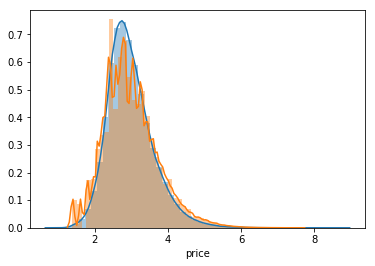

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(oof_preds)
sns.distplot(y)
plt.show()

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1, min_samples_leaf=50)
oof_X = np.hstack((oof_preds1, oof_preds2, oof_preds3))
print(oof_X.shape)
oof2 = cross_val_predict(rfr, oof_X, y , cv=5, verbose=10)
rmse(y, oof2)

(1481658, 3)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.3s remaining:    0.0s


1.988219376342803 4.961022181829234


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s finished


0.4244249992307715

In [11]:
#adding GRU - worsened performance
#Flatten - worse

In [105]:
nnet1.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
#test_preds1 = nnet1.predict(test_data)

[<tf.Tensor 'reshape_269/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_270/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_271/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_272/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_273/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_274/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_275/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_276/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_277/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_42:0' shape=(?, 21) dtype=float32>]
(1444616, 32) (37042, 32) (1444616,) (37042,)
Train on 1444616 samples, validate on 37042 samples
Epoch 1/5
1444616/1444616 [==============================] - 27s 19us/step - loss: 0.4757 - val_loss: 0.2114
Epoch 2/5
1444616/1444616 [==============================] - 18s 12us/step - loss: 0.1769 - val_loss: 0.1757
Epoch 3/5
1444616/1444616 [==============

In [17]:
nnet2.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds2 = nnet2.predict(test_data)

[<tf.Tensor 'reshape_55/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_56/Reshape:0' shape=(?, 25) dtype=float32>, <tf.Tensor 'reshape_57/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_58/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_59/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_60/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_61/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_62/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_63/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'dense_cols_11:0' shape=(?, 17) dtype=float32>]
(1452024, 32) (29634, 32) (1452024,) (29634,)
Train on 1452024 samples, validate on 29634 samples
Epoch 1/6
1452024/1452024 [==============================] - 18s 12us/step - loss: 0.4859 - val_loss: 0.2130
Epoch 2/6
1452024/1452024 [==============================] - 15s 10us/step - loss: 0.2104 - val_loss: 0.1876
Epoch 3/6
1452024/1452024 [=======================

In [12]:
nnet3.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds3 = nnet3.predict(test_data)

test_preds = (1/3)*(test_preds1 + test_preds2 + test_preds3)
print("Write out submission")
submission: pd.DataFrame = test_data[['test_id']]
submission['price'] = np.expm1(test_preds)
submission.price = submission.price.clip(3, 2000)
submission.to_csv("embedding_nn_v2.csv", index=False)

[<tf.Tensor 'reshape_136/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_137/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_138/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_139/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_140/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_141/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_142/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_143/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_144/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_30:0' shape=(?, 21) dtype=float32>]
(1444616, 32) (37042, 32) (1444616,) (37042,)
Train on 1444616 samples, validate on 37042 samples
Epoch 1/5
1444616/1444616 [==============================] - 24s 17us/step - loss: 0.5103 - val_loss: 0.2013
Epoch 2/5
1444616/1444616 [==============================] - 18s 12us/step - loss: 0.1956 - val_loss: 0.1780
Epoch 3/5
1444616/1444616 [==============

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
